In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from datetime import datetime

In [2]:
csv = 'archivo_ordenado.csv'
df = pd.read_csv(csv)

In [3]:
# Ver las primeras filas del DataFrame
df.head()

,Unnamed: 0,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,nombre_estacion_Retiro,calle_prin_Retiro,calle_secu_Retiro,colonia_Retiro,alcaldia_Retiro,...,nombre_estacion_Arribo,calle_prin_Arribo,calle_secu_Arribo,colonia_Arribo,alcaldia_Arribo,latitud_Arribo,longitud_Arribo,sitio_de_e_Arribo,Fecha_Arribo,Hora_Arribo
0,0,M,26.0,5180930,568,Doctor Barragán_Doctor Erazo,Doctor Barragán,Doctor Erazo,Doctores,Cuauhtemoc,...,Manuel J. Othón_José T. Cuellar,Manuel J. Othón,José T. Cuellar,Obrera,Cuauhtemoc,19.414595,-99.135886,Arroyo,01/01/2025,00:00:03
1,1,F,54.0,3653953,283,Av. Coyoacán_Rafael Dondé,Av. Coyoacán,Rafael Dondé,Del Valle Norte,Benito Juarez,...,Cumbres De Maltrata_Uxmal,Cumbres De Maltrata,Uxmal,Narvarte,Benito Juarez,19.395205,-99.155049,Arroyo,01/01/2025,00:00:41
2,2,M,38.0,7511322,34,Liverpool_Génova,Liverpool,Génova,Juarez,Cuauhtemoc,...,Sonora_Ámsterdam,Sonora,Ámsterdam,Hipodromo,Cuauhtemoc,19.412982,-99.166936,Arroyo,01/01/2025,00:00:59
3,3,M,41.0,3804572,258,Circuito Interior_Juan Escutia,Circuito Interior,Juan Escutia,Condesa,Cuauhtemoc,...,Reforma_Praga,Reforma,Praga,Juarez,Cuauhtemoc,19.425280,-99.171099,Banqueta,01/01/2025,00:01:08
4,4,M,35.0,3848405,43,Revillagigedo_Juárez,Revillagigedo,Juárez,Centro,Cuauhtemoc,...,Jalapa_Puebla,Jalapa,Puebla,Roma Norte,Cuauhtemoc,19.422288,-99.162138,Arroyo,01/01/2025,00:01:17


In [4]:
# Convertir las columnas de fecha y hora
df['Fecha_Arribo'] = pd.to_datetime(df['Fecha_Arribo'], format='%d/%m/%Y')
df['Hora_Arribo'] = pd.to_datetime(df['Hora_Arribo'], format='%H:%M:%S').dt.time

In [5]:
# Crear nuevas columnas que representen la hora y el día
df['Hora_Num'] = df['Fecha_Arribo'].dt.hour + df['Hora_Arribo'].apply(lambda x: x.hour / 60)
df['Dia_Num'] = df['Fecha_Arribo'].dt.dayofweek  # Lunes=0, Domingo=6

In [6]:
# Filtrar las columnas relevantes para el clustering
X = df[['latitud_Arribo', 'longitud_Arribo', 'Hora_Num', 'Dia_Num']]

In [7]:
# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

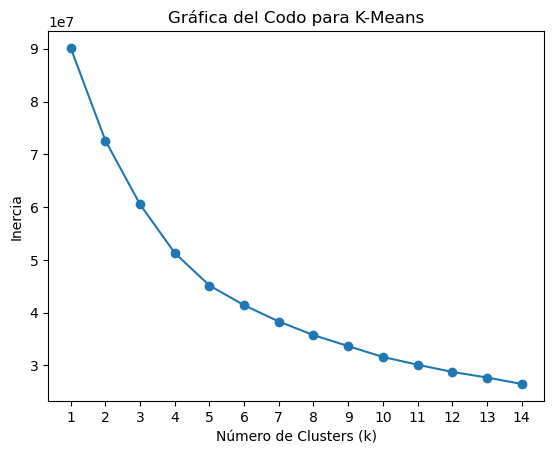

In [8]:
# Gráfica de codo
inertia = []
k_values = range(1, 15)  # Cambia el rango según necesites

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotear la gráfica del codo

plt.plot(k_values, inertia, marker='o')
plt.title('Gráfica del Codo para K-Means')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.xticks(k_values)

plt.show()

In [9]:
# Aplicar el algoritmo K-Means
n_clusters = 5  # Cambia el número de clusters según sea necesario
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)

KMeans(n_clusters=5, random_state=42)

In [10]:
# Agregar las etiquetas de cluster al DataFrame
df['Cluster'] = kmeans.labels_

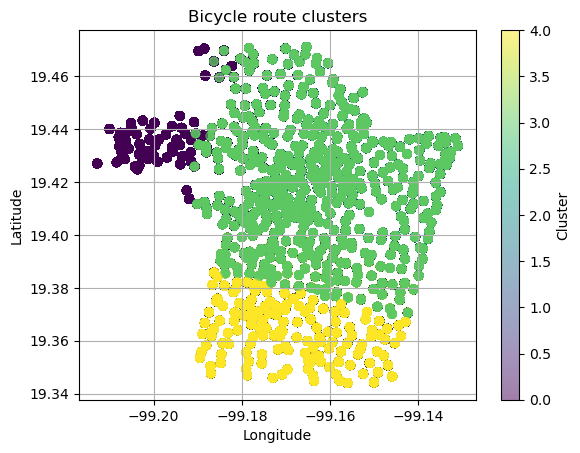

In [11]:
# Visualización de los clusters
plt.scatter(df['longitud_Arribo'], df['latitud_Arribo'], c=df['Cluster'], cmap='viridis', alpha=0.5)
plt.title('Bicycle route clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

In [12]:
# Análisis de los clusters
cluster_summary = df.groupby('Cluster').agg({
    'Genero_Usuario': 'count',
    'Edad_Usuario': 'mean',
    'Ciclo_Estacion_Arribo': 'first',
    'nombre_estacion_Arribo': 'first'
}).reset_index()

print(cluster_summary)

   Cluster  Genero_Usuario  Edad_Usuario Ciclo_Estacion_Arribo  \
0        0         2866632     33.452690                   461   
1        1         4678517     34.303306                   572   
2        2         5611446     33.421283                    87   
3        3         5275067     33.563948                    55   
4        4         4107727     33.815932                   645   

                              nombre_estacion_Arribo  
0  Presa Don Martín_Boulevard Miguel De Cervantes...  
1                    Manuel J. Othón_José T. Cuellar  
2                          Gante_Venustiano Carranza  
3                                  5 De Mayo_Bolívar  
4                                    Saratoga_Ajusco  


In [13]:
# Evaluar rendimiento del modelo de clustering
inertia = kmeans.inertia_
print(f"Inercia: {inertia}")


Inercia: 45139196.3453619


In [14]:
# Tomar una muestra más pequeña si es necesario
sample_size = 100000  # Ajusta según tus necesidades
X_sample = X_scaled[np.random.choice(X_scaled.shape[0], sample_size, replace=False)]

# Calcular el Silhouette Score
silhouette_avg = silhouette_score(X_sample, kmeans.labels_[:sample_size])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: -0.0031705772574989926
